---
## Summary
- Images from PV01 folders are 256x256 whereas ones from PV03 folders are 1024x1024.
- The mask has binary pixel values. However, while one is always 0, the other may be anyting up to 256.
- The images are RGB (sounds like Pillow defaults to RGB so this should be confirmed when image is loaded using TensorFlow).
- Seems like it is OK to resize the image and mask.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

---
## Inital exploration
- Load and compare images/masks
- Find out size and color format (e.g. RGB, RGBA, etc.)
- Checkout masks

In [2]:
def load_image_mask_pair(img_path: str) -> tuple[Image, Image]:
    if len(img_path.split('.')) != 2:
        raise ValueError('Invalid image path, must include file extension')
    root, extension = img_path.split('.')
    img = Image.open(img_path)
    mask = Image.open(root + '_label.' + extension)
    return img, mask

In [3]:
img_path_rt_brick = 'data/Hou/PV01_Rooftop_Brick/PV01_324942_1203839.bmp'
img_path_rt_concrete0 = 'data/Hou/PV01_Rooftop_FlatConcrete/PV01_325119_1204074.bmp'
img_path_rt_concrete1 = 'data/Hou/PV01_Rooftop_FlatConcrete/PV01_325125_1204226.bmp'
img_path_gnd_crop = 'data/Hou/PV03_Ground_Cropland/PV03_315256_1194611.bmp'
img_path_gnd_water = 'data/Hou/PV03_Ground_WaterSurface/PV03_315516_1198977.bmp' # this could potentially be an issue, the mask seems to be incomplete

img, mask = load_image_mask_pair(img_path_gnd_water)

In [4]:
def display_img_and_mask(img: Image, mask: Image) -> None:
    _, axs = plt.subplots(1, 2)
    axs[0].imshow(img)
    axs[1].imshow(mask)

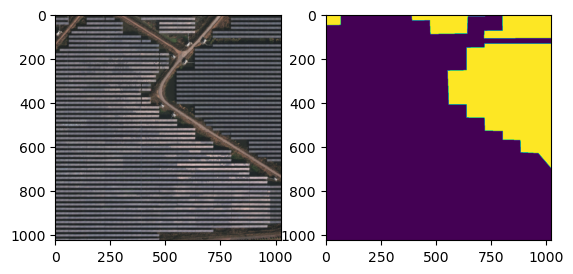

In [5]:
display_img_and_mask(img, mask)

In [6]:
def print_shape_of_image(img: Image) -> None:
    img_arr = np.array(img)
    print(f'Shape: {img_arr.shape}')

In [7]:
print('Image ', end='')
print_shape_of_image(img)
print('Mask ', end='')
print_shape_of_image(mask)

Image Shape: (1024, 1024, 3)
Mask Shape: (1024, 1024)


The image is RGB e.g. each pixel is 3D. However, each pixel in the mask is binary. This is expected

In [8]:
def plot_rgb_hist(img: Image) -> None:
    hist = img.histogram()

    color_hist = pd.DataFrame(
        {
            'r': hist[:256],
            'g': hist[256:512],
            'b': hist[512:],
        }
    )

    _, axs = plt.subplots(1, 3)
    for color, ax in zip(('r', 'g', 'b'), axs):
        sns.histplot(color_hist, x=color, ax=ax, color=color)

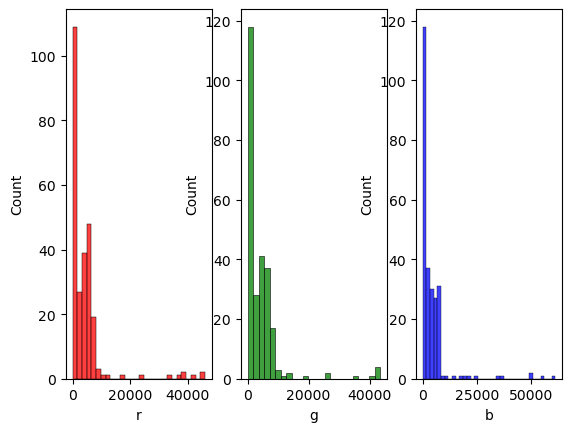

In [9]:
plot_rgb_hist(img)

In [10]:
def mask_pixel_values(mask: Image) -> list[int]:
    mask_values = np.array(mask.histogram())
    return list(*np.where(mask_values > 0))    

In [11]:
unique_pixel_values = mask_pixel_values(mask)
print('Mask Pixel Values:', unique_pixel_values)

Mask Pixel Values: [0, 125]


From multiple runs, it seems that:
- Images:
  - always 256 x 256 x 3 (RGB)
- Mask
  - always 256 x 256
  - the "true" values for the masks vary, but are always > 0

---
## Assert Statements
Could be useful to make into unit tests to validate the dataset

In [12]:
assert len(unique_pixel_values) == 2

In [13]:
assert unique_pixel_values[0] == 0

In [14]:
assert unique_pixel_values[1] > 0 

Other assert statements:
- `assert image_shape == (256, 256, 3)`
- `assert mask_shape == (256, 256, 1)`

---
## Check Resizing
Check that the mask and it's target still overlap when the image is resized 

In [15]:
def resize_and_overlay(img: Image, mask: Image, w=256, h=256) -> None:
    # resize image and mask
    img = img.resize((w, h))
    mask = mask.resize((w, h))
    # overlay mask on image
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)

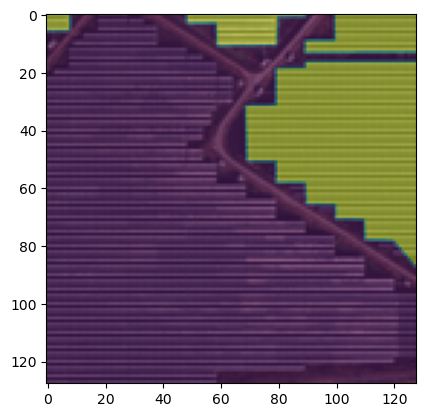

In [16]:
resize_and_overlay(img, mask, w=128, h=128)

It's a bit crude, but from looking by eye it seems that resizing the image and mask is ok. It is worth checking again using the TensorFlow function